## Random forest

랜덤 포레스트 (random forest)는 bagged tree를 트리 간의 decorrelation을 통해 향상시킨 개념으로 bagging 앙상블 기법 중 하나이다.

- 따라서 일반적인 bagging 보다 보통 더 좋은 성능을 보인다.

일반적인 bagging에서 bootstrap을 통해 만들어진 훈련 데이터 셋들은 서로 공유하는 데이터가 많아 이를 통해 만들어진 tree들은 높은 상관관계를 지니고 이에 따라 높은 variance를 유발한다.

랜덤 포레스트에서는 트리를 분할할 때, $p$개의 predictor중 임의로 선택된 $m$개의 predictor들을 후보로 하여 트리 분할을 진행한다.

- 일반적으로 $m \approx \sqrt{p}$로 한다.

- 즉, 랜덤 포레스트 방법은 트리 분할이 일어날 때 의도적으로 일부 predictor를 제외한다.

제외된 predictor들에는 strong predictor들도 있을 수 있는데 이들이 제외됨으로써 트리 간의 decorrelation이 발생한다.

이러한 제외 과정이 없는 bagging에서는 사실 트리들이 모두 비슷비슷하게 생겼을 가능성이 높다.

아래 그림은 bagging과 random forest 방법에서의 에러를 계산한 예제로, random forest의 좋은 성능을 보여주는 예제이다.

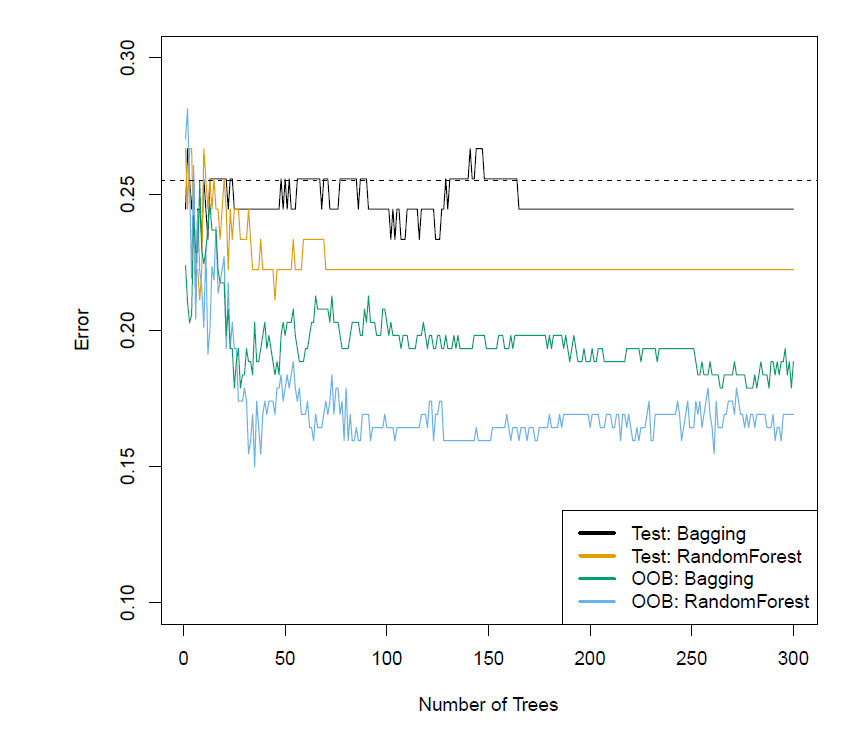

#### 예제 : make_moons

초승달 모양 클러스터 두 개 형상의 데이터를 생성하는 [```make_moons```](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)를 활용한 예제

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

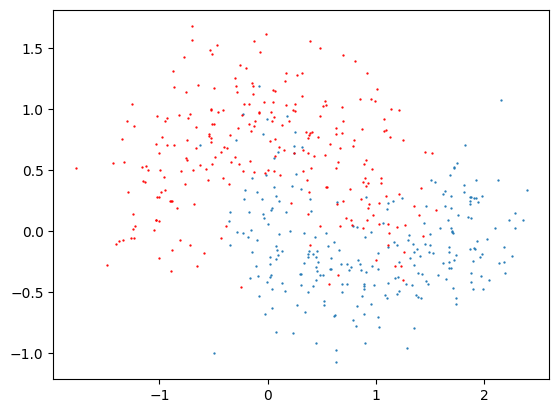

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[y==1, 0], X[y==1, 1], s = 0.4)
plt.scatter(X[y==0, 0], X[y==0, 1], s = 0.4, color="red")

plt.show()

먼저 validation set 방법을 이용하여 tree와 bagging의 accuracy를 비교해 본다.

[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)는 실제값과 모형을 통한 예측값을 비교하여 예측이 얼마나 정확한지를 평가한다.

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

단독의 `DecisionTreeClassifier`를 사용한 예제를 먼저 살펴보자.

나중에 살펴볼 bagging보다 더 적은 accuracy score를 보인다.

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.792


아래 방법과 동일한 결과

In [5]:
tree_clf.score(X_test, y_test)

0.792

그 다음 적은 수(`n_estimators`)의 decision tree를 사용한 bagging이다.

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=5)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.864


Decision tree의 개수인 `n_estimators`를 늘려보자.

accuracy score가 향상되었다.

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=300, oob_score=True)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.856


Decision boundary를 그려보자.

[`sklearn.inspection.DecisionBoundaryDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)는 경계선을 그리기 위한 좋은 툴을 제공한다.

[`DecisionBoundaryDisplay.from_estimator`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator)의 첫번째 파라미터인 `estimator`에 대상이 되는 훈련된 classifier를 넣어 준다.

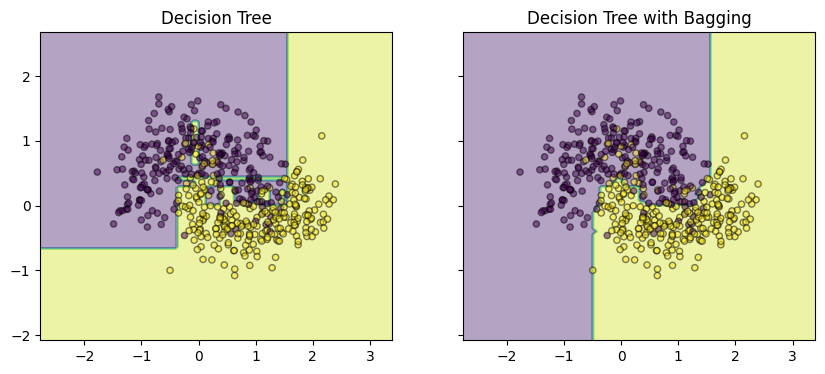

In [8]:
from sklearn.inspection import DecisionBoundaryDisplay

_, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10,4))

for idx, clf, tt in zip([0, 1],
                        [tree_clf, bag_clf],
                        ["Decision Tree", "Decision Tree with Bagging"]):
    
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx], response_method="predict"
    )
    axarr[idx].scatter(X[:, 0], X[:, 1], c = y, s = 20, edgecolor="k", alpha=0.5)
    axarr[idx].set_title(tt)

plt.show()

In [9]:
# 모든 데이터로 훈련하고 bagging 방법에 대한 oob score = 1 - clf.oob error를 계산
BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=300, bootstrap=True, oob_score=True)\
.fit(X, y).oob_score_

0.886

이제 랜덤 포레스트를 적용해 보자.

[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

* ```n_estimators``` : default=100, 트리의 숫자
* ```max_features``` : ```max_features=sqrt(n_features)``` with default
* `max_depth` :  트리의 최대 깊이로, `None`이면 모든 잎이 pure하거나 모든 잎에 `min_samples_split` 샘플보다 적은 샘플이 포함될 때까지 노드가 확장됨
* `min_samples_split` : default = 2 
* `max_leaf_nodes` : 최대 leaf 노드의 수
* `bootstrap` : bool값으로 default=True이다. 즉, 새로운 트리에 대해 기본적으로 bootstrap 데이터를 이용한다.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rnd_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# 훈련
rnd_clf.fit(X_train, y_train)

In [11]:
# prediction
y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.872


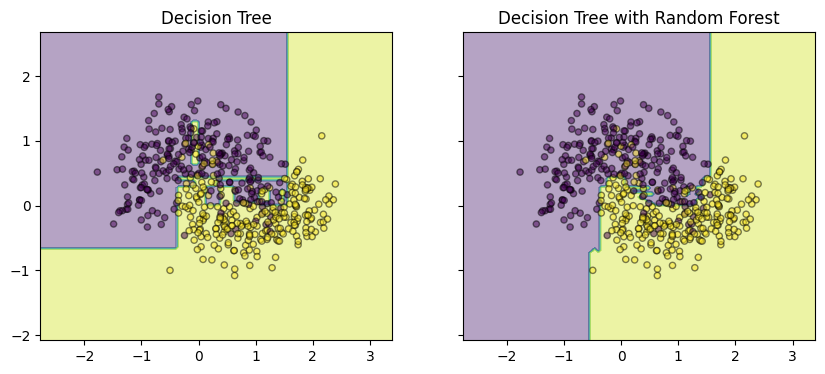

In [12]:
_, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10,4))

for idx, clf, tt in zip([0, 1],
                        [tree_clf, rnd_clf],
                        ["Decision Tree", "Decision Tree with Random Forest"]):
    
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx], response_method="predict"
    )
    axarr[idx].scatter(X[:, 0], X[:, 1], c = y, s = 20, edgecolor="k", alpha=0.5)
    axarr[idx].set_title(tt)

plt.show()

In [13]:
# 모든 데이터로 훈련하고 oob score를 계산
RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, oob_score=True).fit(X, y).oob_score_

0.884

### 예제 : Bike Sharing data

[Bike Sharing Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) 데이터를 이용하여 `cnt`를 예측하는 예제

In [14]:
import pandas as pd
url = "https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter01/bike_rentals_cleaned.csv"
df = pd.read_csv(url)
df

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,1.0,1.0,12,0.0,4.0,1.0,2,0.254167,0.226642,0.652917,0.350133,2114
727,728,1.0,1.0,12,0.0,5.0,1.0,2,0.253333,0.255046,0.590000,0.155471,3095
728,729,1.0,1.0,12,0.0,6.0,0.0,2,0.253333,0.242400,0.752917,0.124383,1341
729,730,1.0,1.0,12,0.0,0.0,0.0,1,0.255833,0.231700,0.483333,0.350754,1796


In [15]:
X = df.loc[:,"season":"windspeed"]
y = df.loc[:,"cnt"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

회귀문제라 [`sklearn.ensemble,RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)를 이용한다.

`RadomForestRegressor`는 `max_features`의 기본값은 1.0이다. 

따라서 제곱근 규칙을 적용하려면 `"sqrt"`를 인자로 사용한다.

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt')

In [18]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
y_pred = rf.predict(X_test)

Random forest classifier의 [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_)는 각 feature 변수들의 중요도를 계산한다.

중요도 값은 일반적으로 0에서 1 사이의 실수로 표현되며, 모든 특성의 중요도 값의 합은 1이다.

중요도 값이 클수록 해당 특성이 모델 예측에 더 큰 영향을 미치는 것으로 해석할 수 있다.

In [20]:
# feature 중요도와 함께 출력
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
importances_df.sort_values(by='importance', ascending=False, inplace=True)
print(importances_df)

       feature  importance
1           yr    0.236328
8        atemp    0.216627
7         temp    0.197111
0       season    0.097612
9          hum    0.080099
2         mnth    0.063536
10   windspeed    0.042369
6   weathersit    0.039064
4      weekday    0.019216
5   workingday    0.005756
3      holiday    0.002282


`.estimators_` 속성은 생성된 결정 트리들의 리스트를 반환한다.

그 중 하나의 트리를 선택해 볼 수 있다.

In [21]:
rf.estimators_[0]

DecisionTreeRegressor(max_features='sqrt', random_state=977427113)

트리를 그림으로 표현해 볼 수 있다.

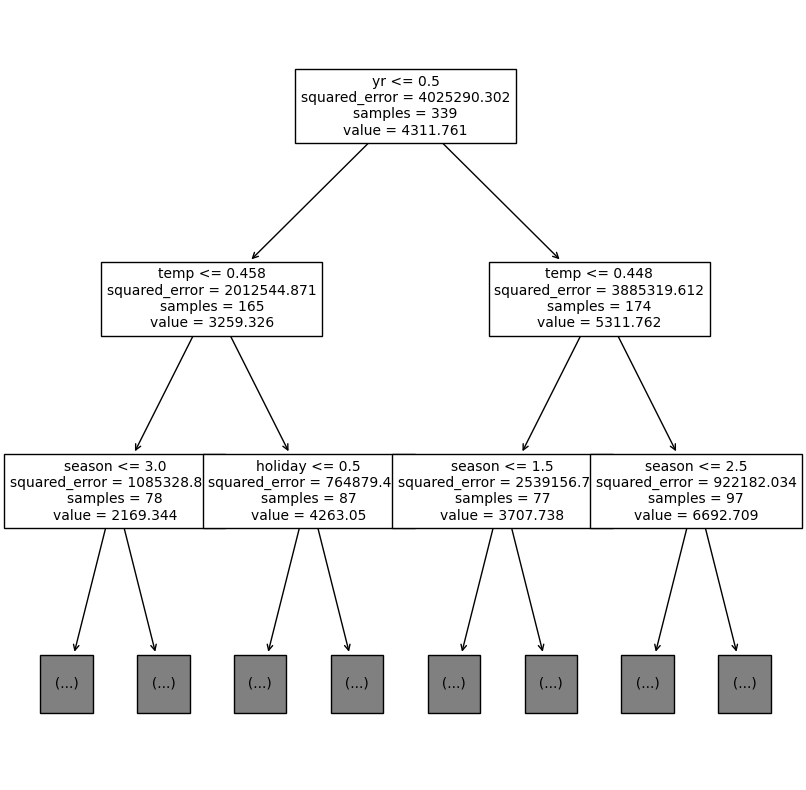

In [22]:
from sklearn.tree import plot_tree 
plt.figure(figsize=(10,10))
plot_tree(rf.estimators_[0], feature_names=X_train.columns, max_depth=2,  fontsize=10)
plt.show()

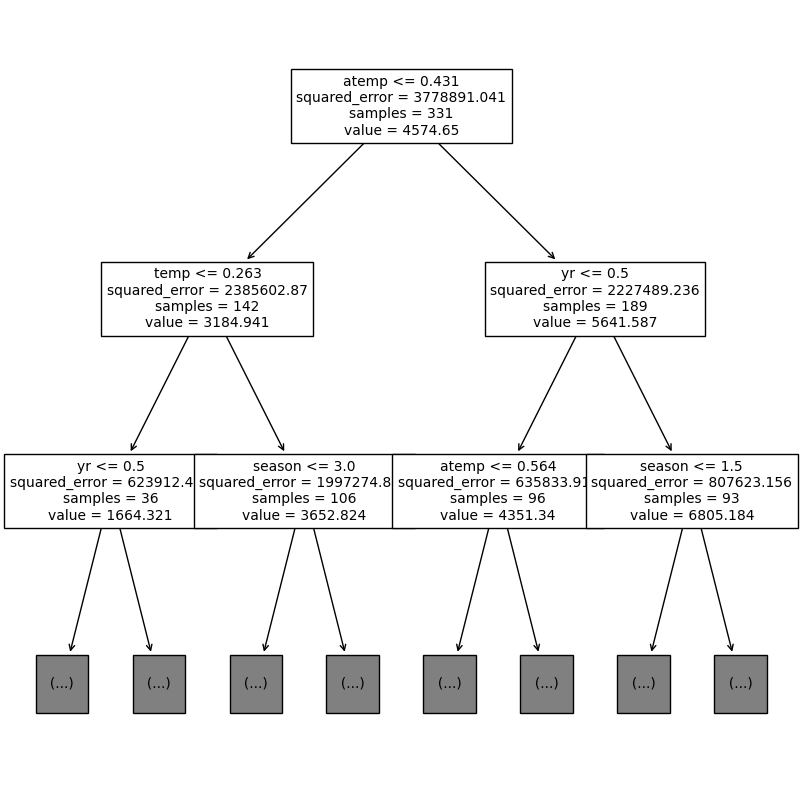

In [23]:
plt.figure(figsize=(10,10))
plot_tree(rf.estimators_[1], feature_names=X_train.columns, max_depth=2,  fontsize=10)
plt.show()

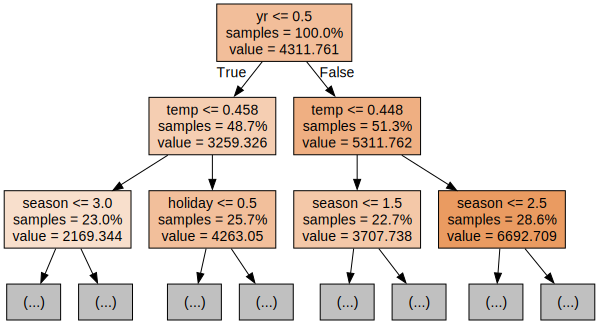

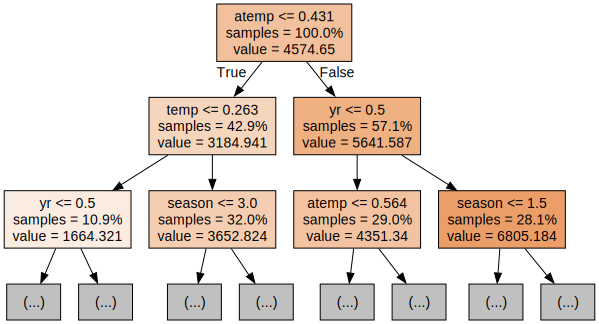

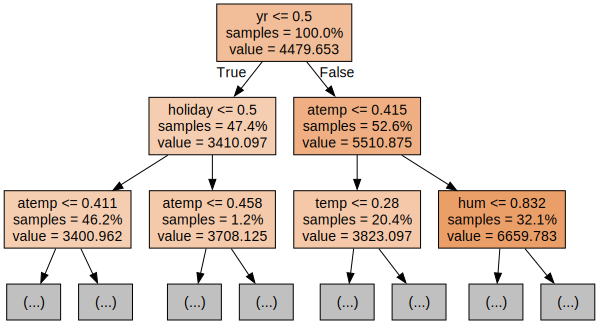

In [24]:
import graphviz
from sklearn.tree import export_graphviz

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

#### k-fold cross-validation error 추정해 보기

[`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)를 이용하여 편리하게 k-fold cross-validation 에러를 계산할 수 있다.

* 여기서 `'neg_mean_squared_error'`는 MSE의 음수값을 나타내므로, mse 평균을 구할 때는 다시 마이너스를 취한다.

* 이는 `cross_val_score` 함수의 기본 동작은 높은 값일수록 좋은 성능으로 간주하도록 되어 있어, 음의 평균 제곱 오차를 사용하도록 구현되어 있다.

`X`와 `y` 전체를 인자로 전달하여 에러를 계산한다.

In [25]:
from sklearn.model_selection import cross_val_score 
import numpy as np

mse_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
mse_mean = - mse_scores.mean()

print("RMSE:", np.sqrt(mse_mean))

RMSE: 1032.3026672365195


단순 트리 모형과 비교

In [26]:
from sklearn.tree import DecisionTreeRegressor

tr = DecisionTreeRegressor()

tr_mse_scores = cross_val_score(tr, X, y, cv=5, scoring='neg_mean_squared_error')
tr_mse_mean = - tr_mse_scores.mean()

print("RMSE:", np.sqrt(tr_mse_mean))

RMSE: 1273.882244599537


Bagging과 비교

In [27]:
from sklearn.ensemble import BaggingRegressor

bc = BaggingRegressor(estimator=DecisionTreeClassifier())

bc_mse_scores = cross_val_score(bc, X, y, cv=5, scoring='neg_mean_squared_error')
bc_mse_mean = - bc_mse_scores.mean()

print("RMSE:", np.sqrt(bc_mse_mean))

RMSE: 1720.1550077553493


### 예제 : 연봉 데이터를 이용한 분류 문제

In [37]:
import pandas as pd
df_census = pd.read_csv("https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/census_cleaned.csv")

In [52]:
df_census

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32557,40,154374,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [38]:
X = df_census.iloc[:,:-1]
y = df_census.iloc[:,-1]

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y)

분류 문제이므로 RandomForestClassifier를 이용한다.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)

scores = cross_val_score(rf, X, y, cv=5)

print('정확도:', np.round(scores, 3))

print('정확도 평균: %0.3f' % (scores.mean()))

정확도: [0.858 0.855 0.858 0.862 0.86 ]
정확도 평균: 0.859


In [48]:
# 트리와의 비교
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
scores_tree = cross_val_score(clf, X, y, cv=5)
print('정확도:', np.round(scores_tree, 3))
print('정확도 평균: %0.3f' % (scores_tree.mean()))

정확도: [0.814 0.811 0.807 0.818 0.813]
정확도 평균: 0.813


In [50]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=2)

In [51]:
# feature 중요도와 함께 출력
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
importances_df.sort_values(by='importance', ascending=False, inplace=True)
print(importances_df)

                                       feature  importance
1                                       fnlwgt    0.159429
0                                          age    0.143116
2                                education-num    0.112311
3                                 capital-gain    0.100757
5                               hours-per-week    0.081537
..                                         ...         ...
78  native-country_ Outlying-US(Guam-USVI-etc)    0.000024
66                    native-country_ Honduras    0.000018
24                    occupation_ Armed-Forces    0.000018
9                      workclass_ Never-worked    0.000008
65          native-country_ Holand-Netherlands    0.000000

[92 rows x 2 columns]


### 다른 예제  : The elements of statistical learning

[`datasets.make_hastie_10_2`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html)는 2개의 클래스와 10개의 특성을 가진 총 12000개의 데이터 포인트를 생성한다.

분류 알고리즘의 성능을 평가하기 위한 벤치마크 데이터셋으로 사용된다.

In [33]:
from sklearn import datasets
import matplotlib.pyplot as plt

X, y = datasets.make_hastie_10_2(n_samples=12_000, random_state=1)

X

array([[ 1.62434536, -0.61175641, -0.52817175, ..., -0.7612069 ,
         0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071, -0.3224172 , ..., -0.87785842,
         0.04221375,  0.58281521],
       [-1.10061918,  1.14472371,  0.90159072, ..., -0.93576943,
        -0.26788808,  0.53035547],
       ...,
       [-0.93116013, -1.66204029,  0.30451552, ..., -0.13420095,
         0.29183149, -0.43300684],
       [-1.3787448 ,  0.83384136, -1.53900483, ...,  0.89981334,
        -1.44271785,  2.51028547],
       [ 0.82776805,  2.04855517,  2.77822335, ...,  0.12579842,
        -0.1916412 ,  0.67553921]])

일부만을 선택하여 그림을 그려보자.

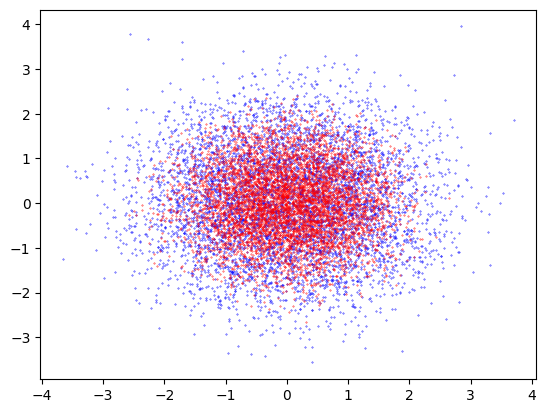

In [34]:
plt.scatter(X[y==1, 0], X[y==1, 1], color = "blue", s = 0.1)
plt.scatter(X[y==-1, 0], X[y==-1, 1], color = "red", s = 0.1)
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2_000, shuffle=False
)

먼저 estimator의 수를 증가시켜 가면서 각 경우마다 bagging의 error를 측정해 보자.

In [54]:
# 시간이 다소 오래 걸릴 수 있다.
# bagging
n_estimators_list = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]
bc_errs = []
for n_estimators in n_estimators_list:
    bc = BaggingClassifier(n_estimators = n_estimators)
    bc.fit(X_train, y_train)
    bc_err = 1 - bc.score(X_test, y_test)
    bc_errs.append(bc_err)

In [55]:
bc_errs

[0.18818326986856648,
 0.16705564426974573,
 0.16742414936739958,
 0.15378946075420707,
 0.14875322441960448,
 0.14678786389878395,
 0.1456823486058224,
 0.14420832821520702,
 0.14961306964746346,
 0.1449453384105147]

다음은 estimator의 수를 증가시켜 가면서 각 경우마다 random forest의 error를 측정해 보자.

In [56]:
rf_errs = []
for n_estimators in n_estimators_list:

    rf = RandomForestClassifier(n_estimators = n_estimators)
    rf.fit(X_train, y_train)
    rf_err = 1 - rf.score(X_test, y_test)
    rf_errs.append(rf_err)

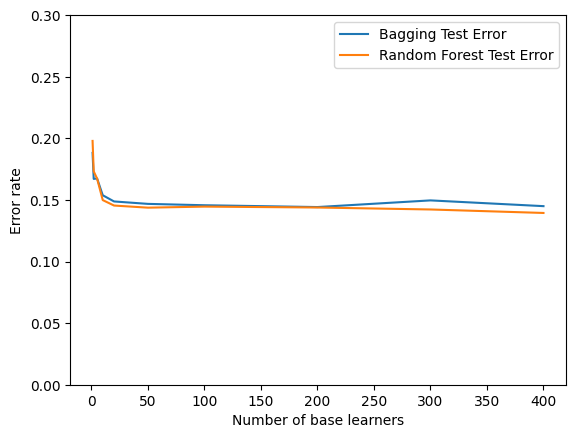

In [57]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(
    n_estimators_list,
    bc_errs,
    label="Bagging Test Error")

ax.plot(
    n_estimators_list,
    rf_errs,
    label="Random Forest Test Error")


ax.set_ylim((0.0, 0.3))
ax.set_xlabel("Number of base learners")
ax.set_ylabel("Error rate")

plt.legend()

plt.show()